## MSDS 7331: Data Mining
## Lab Two: Classification


#### Paticia Attah
#### Linda Eliasen

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedShuffleSplit,KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,plot_confusion_matrix,recall_score
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import GridSearchCV
import math
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.classifier import ROCAUC,ClassPredictionError,ConfusionMatrix

import warnings
warnings.filterwarnings("ignore") # ignore warnings for clean report

## Data Preparation Part 1
This is the initial dataset that is divided into 3 groups(certified, certified-withdrawn, denied), however the targer categories were reduced to certified and denied because the certified withdrawn is ultimately certified aplications that the employer decided to withdraw this does not make any impact on our goal of finding features that cause applications to be certified or denied. This data has been cleaned and outliers removed from the previous lab. Also the data was very unbalanced with majority of the applications being certified so measures were taken to take the imbalance into consideration.

###  Steps for the data preparation
1. Creating Dummy variables and dropping unnecesary variables
3. Imputation of missing values
4. Reducing the certified values to create a less unbalanced dataset


<AxesSubplot:title={'center':'count (target)'}>

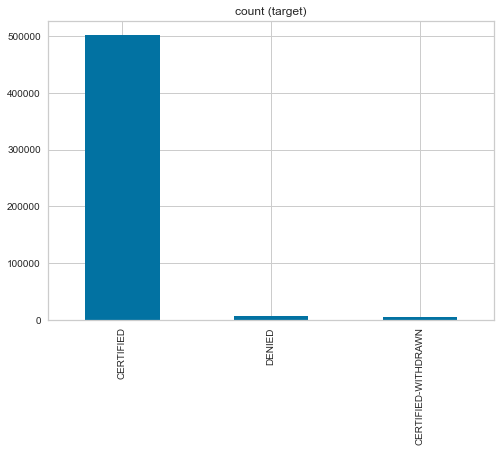

In [2]:
df = pd.read_csv ('uncleaned_Visa_Data.csv')
df = df.sample(frac = 1) 
df['CASE_STATUS'].value_counts().plot(kind='bar', title='count (target)')

## Data Preparation Part 1
### Step 1: Creating Dummy variables and dropping unnecesary variables
At this point we are removing the categorical columns and replacing them with dummy variable that will 0,1 value for the model. Out target variable is 1 which means certified and 0 which specifies denied. In this phase we also removed some unnecesarry varibale incuding the unit of pay and wage unit of pay which specifies how the salary was recorded for an example weekly, bi-weekly monthly.

Some features that were dropped include variables that had very large number of categories including WORKSITE_CITY, EMPLOYER_NAME, JOB_TITLE these variables had numerous categories and may not have substantial effect on the predicting the dependent variable since the categories were so many in number.

The next set of variable that were removed were some created variables that specified the unit that the pay was recorded in either bi-weekly, weekly or monthly as this would not impact the have any explanatory value if found significant these features were PW_UNIT_OF_PAY, WAGE_UNIT_OF_PAY. Also PREVAILING_WAGE, and WAGE_RATE_OF_PAY were dollar amounts of the pay that was being oaid by the employer and the currnet market rate of pay these needed to be removed because they were not recorded with a uniform value for example some were recorded with the bi-weekly rate and some were recorded with annual amout so since the dollar amount are not uniform it will distort the predicting effciency of the model.


After the necccessary variables are removed one hot encoding is used on the variables with multiple categories (having less than 50 categories). These values are then joined to the original data set. The data is then divided into the target variable and the independent variables. The data is then scaled only the independent variables.

In [3]:
WILLFUL_VIOLATOR = pd.get_dummies(df.WILLFUL_VIOLATOR, prefix='WILL_VIOL',drop_first=True)
df = pd.concat([df, WILLFUL_VIOLATOR], axis=1)

SOC_GROUP = pd.get_dummies(df['SOC_GROUP'],drop_first=True)
df = pd.concat([df, SOC_GROUP], axis=1)

PW_WAGE_LEVEL = pd.get_dummies(df.PW_WAGE_LEVEL, prefix='PW_LEVEL',drop_first=True)
df = pd.concat([df, PW_WAGE_LEVEL], axis=1)

AGENT_REPRESENTING_EMPLOYER = pd.get_dummies(df.AGENT_REPRESENTING_EMPLOYER, prefix='AGENT_REP',drop_first=True)
df = pd.concat([df, AGENT_REPRESENTING_EMPLOYER], axis=1)  

H1B_DEPENDENT = pd.get_dummies(df.H1B_DEPENDENT, prefix='H1B_DEP',drop_first=True)
df = pd.concat([df, H1B_DEPENDENT], axis=1)

LABOR_CON_AGREE = pd.get_dummies(df.LABOR_CON_AGREE, prefix='LABOR_CON_AGREE',drop_first=True)
df = pd.concat([df, LABOR_CON_AGREE], axis=1)

SUPPORT_H1B = pd.get_dummies(df.SUPPORT_H1B, prefix='SUPPORT_H1B',drop_first=True)
df = pd.concat([df, SUPPORT_H1B], axis=1)

In [4]:
df1 = df.drop(['EMPLOYER_STATE','DECISION_DATE','CASE_SUBMITTED','CASE_NUMBER',
           'Unnamed: 0','WORKSITE_CITY','EMPLOYER_NAME','PW_UNIT_OF_PAY',
            'EMPLOYER_CITY', 'WORKSITE_STATE', 'SOC_GROUP_Code','SOC_NAME','JOB_TITLE',
            'WAGE_UNIT_OF_PAY','PW_UNIT_OF_PAY','PREVAILING_WAGE','SOC_CODE',
            'WILLFUL_VIOLATOR','PW_WAGE_LEVEL','H1B_DEPENDENT','SOC_GROUP','SUPPORT_H1B',
            'AGENT_REPRESENTING_EMPLOYER','LABOR_CON_AGREE','WAGE_RATE_OF_PAY'], axis=1)

In [5]:
df1 = df1.loc[(df1['CASE_STATUS']=='CERTIFIED') | (df1['CASE_STATUS']=='DENIED')] 
df1['CASE_STATUS'] = np.select([df1.CASE_STATUS=='CERTIFIED'],[1],0)
df1 = df1.sample(frac = 1) 
#np.unique(df1.CASE_STATUS)

# Data Preparation Part 1
#### Step 2 : Simple Imputation for missing values

Using sklearn.impute.KNNImputer for imputaion was used to fill in the empty values in order to save the limited number of Denied category values in the dataset for prediction of the target, since this data set is heavily unbalanced with very small number of Denied applications these values.<br>
In order to make the dataset less heavily unbalanced we removed a large number of certified values from about 400,000 rows to bring the number of certified to approximately 26,000 instances while the Denied was about 6,000 instances. the Imbalance was too large and to upsample the Denied values may cause alter the results of the model producing a misleading better performing model that is why this method was used.

#### Step 3 :  Feature Scaling
The data was seperated to dependent(target) and independent variables then the independent variables were scaled 
using sklearn.preprocessing.StandardScaler this is method where the mean is removed and the data is made to unit variance between 0 and 1. We scaled the data because if a feature has a variance that it's order of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected. In our data set there were a number of continuous variable including TOTAL_WORKERS, 
ANNUALIZED_PREVAILING_WAGE, ANNUALIZED_WAGE_RATE_OF_PAY and others that had scales that were very much higher than the other binary variable of 1 and 0.

In [6]:
from sklearn.impute import KNNImputer

imputer = KNNImputer()
df2 = imputer.fit_transform(df1)

df2 = pd.DataFrame(df2, columns = ['CASE_STATUS', 'TOTAL_WORKERS', 'NEW_EMPLOYMENT',
       'CONTINUED_EMPLOYMENT', 'CHANGE_PREVIOUS_EMPLOYMENT',
       'NEW_CONCURRENT_EMPLOYMENT', 'ANNUALIZED_PREVAILING_WAGE',
       'ANNUALIZED_WAGE_RATE_OF_PAY', 'DAYS_PROCESS', 'WILL_VIOL_Y',
       'Arts, Design, Entertainment, Sports, and Media',
       'Building and Grounds Cleaning and Maintenance',
       'Business and Financial Operations', 'Community and Social Service',
       'Computer and Mathematical', 'Construction and Extraction',
       'Education, Training, and Library', 'Farming, Fishing, and Forestry',
       'Food Preparation and Serving Related',
       'Healthcare Practitioners and Technical', 'Healthcare Support',
       'Installation, Maintenance, and Repair', 'Legal',
       'Life, Physical, and Social Science', 'Management',
       'Office and Administrative Support', 'Personal Care and Service',
       'Production', 'Protective Services', 'Sales and Related',
       'Transportation and Material Moving', 'AGENT_REP_Y', 'H1B_DEP_Y',
       'LABOR_CON_AGREE_Y', 'SUPPORT_H1B_Y'])

In [7]:
df2.isnull().sum()

CASE_STATUS                                       0
TOTAL_WORKERS                                     0
NEW_EMPLOYMENT                                    0
CONTINUED_EMPLOYMENT                              0
CHANGE_PREVIOUS_EMPLOYMENT                        0
NEW_CONCURRENT_EMPLOYMENT                         0
ANNUALIZED_PREVAILING_WAGE                        0
ANNUALIZED_WAGE_RATE_OF_PAY                       0
DAYS_PROCESS                                      0
WILL_VIOL_Y                                       0
Arts, Design, Entertainment, Sports, and Media    0
Building and Grounds Cleaning and Maintenance     0
Business and Financial Operations                 0
Community and Social Service                      0
Computer and Mathematical                         0
Construction and Extraction                       0
Education, Training, and Library                  0
Farming, Fishing, and Forestry                    0
Food Preparation and Serving Related              0
Healthcare P

<AxesSubplot:title={'center':'count (target)'}>

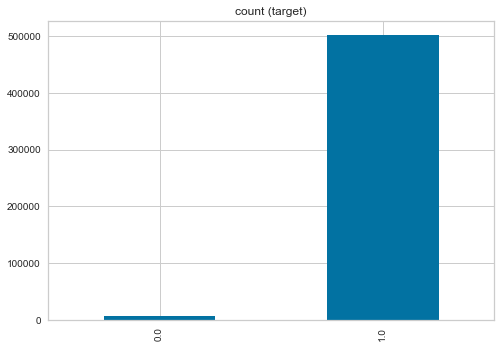

In [8]:
df2['CASE_STATUS'].value_counts().plot(kind='bar', title='count (target)')

In [9]:
df2=df2.sort_values(by=['CASE_STATUS'])
df2=df2.iloc[:, :]
df2=df2.iloc[:33476, :]
df2 = df2.sample(frac = 1) 

In [10]:
VisaStatus_df = df2.groupby(['CASE_STATUS']).size().reset_index(name='counts')
print(VisaStatus_df)

   CASE_STATUS  counts
0          0.0    6676
1          1.0   26800


In [11]:
df2.to_csv(r'/Users/patriciaattah/anaconda_files/yelp_dataset/cleaned_Visa_Data_30000_rows.csv')

<AxesSubplot:title={'center':'count (target)'}>

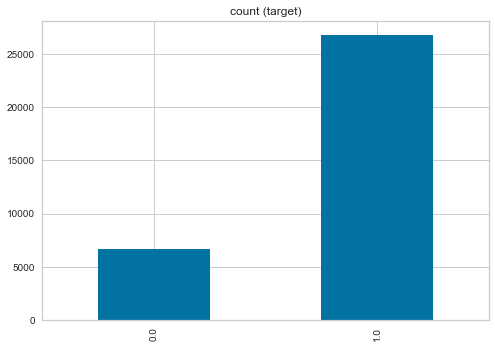

In [12]:
df2['CASE_STATUS'].value_counts().plot(kind='bar', title='count (target)')

# Data Preparation Part 2
Final dataset<br>
The final data set includes 34 columns and 37420 rows there are 25 rows that were made binary with one hot encoding 18 rows were created from the SOC_GROUP variable. All the one hot encoded variables were assigned a type of uint8 which are numbers between 0 to 255, the other variables were assigned to int64 except the variables for pay in dollar currency which were 4 variables that were assigned to float 64. There are 9 continuous variables and 26 binary variables. The target feature has 6,676 Denied values while the Certified had 26,800 values. The data is scaled to unit variance. The only New variables formed were DAYS_PROCESS, ANNUALIZED_PREVAILING_WAGE,
ANNUALIZED_WAGE_RATE_OF_PAY and the Dummy variables formed form the OneHotEncoder for SOC_GROUP. 

# Modeling and Evaluation 1
#### Evaluation Metrics For Classification
When choosing an evaluation metric it is very important that we understand the business challenge we are trying to solve, this will allow us to see what parameters will create a more severe outcome and what measure can reveal that. The metrics being considered will be accuracy and recall. 

In this model it is very important to have the required employees with the skills required to complete a project that a company is undertaking, in time to complete the project. These induviduals are sought for because those skills were not readily avaiable in the job market in the united states and without these employees the company may not complete the job in time or in budget, this will cause loss of future projects and profit for the company. So when applying for these candidates it is very imporatnt that the company has a high likelihood that the employees will be certified.

With this information we see will use __accuracy__ metric to see how many True Positives and True negatives were correct out of the total number of predictions. It tells us generally overall how well the model predicted, however it does not consider the costs of having a mis-classified actual positive (or false negatives). 
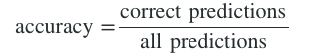

To make sure that the missclassifications are considered we use the recall metric and we are specifically looking at the __recall__ for the Denied category as this is the class that will cause severe setbacks. This is very important to us because our target is classify the candidates that were certified in time for the project duration, It would be very detrimental to the company if the model predicted that the candidate would be Certified while they are actually they would be Denied, this is a measure of __False Negatives__ from the Denied category. False negatives are taken into consideration with recall. Recall is defined as the fraction of examples which were predicted to belong to a class with respect to all of the examples that truly belong in the class.

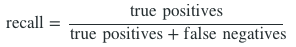
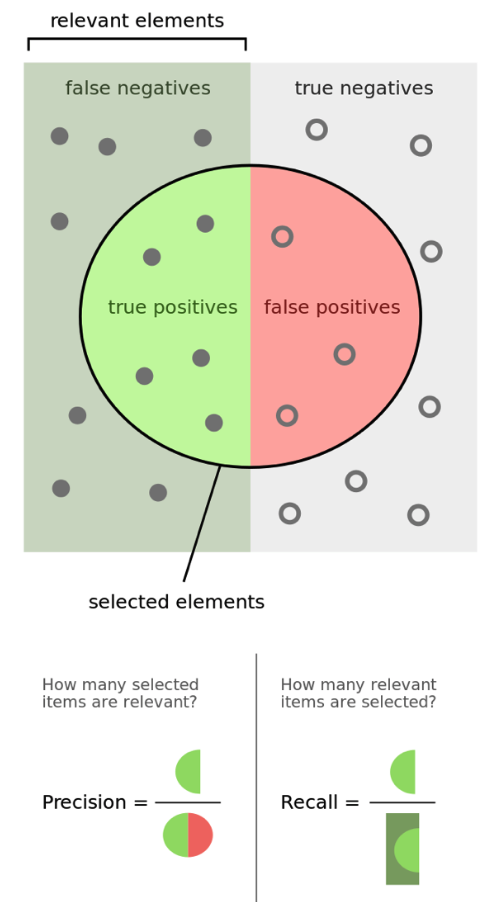

https://www.jeremyjordan.me/evaluating-a-machine-learning-model/

# Modeling and Evaluation 2

#### 10-fold Stratified Cross Validation 
Cross-validation is a resampling procedure used to evaluate machine learning models and can be useful for limited data sizes.
The procedure has a parameter called k that refers to the number of groups that a given data set is to be split into. hence is called k-fold cross-validation. in this model we will be splitting the data into 10. This method picked because it reduced bias, the variance is reduced as k increases so as we have 10 folds the variance should be adequatley reduced. 

Stratified Shuffle Split Method<br>
This cross-validation object is a merge of StratifiedKFold and ShuffleSplit, which returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class. This is important to us because our data set is imbalancd and inorder to keep the integrity of the data by not resampling which may lead to mis-leading high performing model.

#### Test/Train split

In [13]:
# divide data set to x and y and Scale data
scl = StandardScaler()

yy = df2['CASE_STATUS']
xx = df2.drop(['CASE_STATUS'], axis=1)
xx = scl.fit_transform(xx)

In [14]:
a = df2['CASE_STATUS'].values
b = df2.drop(['CASE_STATUS'], axis=1)
b = b.values
b = scl.fit_transform(b)

print(xx.shape)
print(yy.shape)

(33476, 34)
(33476,)


In [15]:
# create train set
import random
random.seed(0)
xx_train,xx_test,yy_train,yy_test = train_test_split(xx,yy,test_size=0.2, random_state=0)
print(yy_train.shape)
print(xx_test.shape)

(26780,)
(6696, 34)


In [16]:
# cross validation
random.seed(10)
num_cv_iterations = 5
cv_object = StratifiedShuffleSplit(n_splits=num_cv_iterations,test_size  = 0.3)

# Modeling and Evaluation 3
#### Classification models 

Models include
1. Random Forest Classifier
2. AdaBoost Classifier 

#### AdaBoost Investigated Parameters:
AdaBoost parameters that were tried were SAMME AND SAMME.R. Discrete SAMME AdaBoost adapts based on errors in predicted class labels whereas real SAMME.R uses the predicted class probabilities. The base_estimator must support calculation of class probabilities if the SAMME.R is to be used. In this case we use the default algorithm setting which is decision trees and this supports probabilities. 

After trial and errot it was determined that the SAMME.R produced the best overall results and in regards to our main metric of recall. SAMME.R also outperformed SAMME when considering the Denied category of the recall metric.Also three different learning rates were checked 1.0, 0.8 and 0.5 with grid search and we saw that 1.0 learning rate was the best. Learning rate shrinks the contribution of each classifier by the learning rate.

####  Random forest Investigated Parameters:
Random forest parameter search was criterion this function to measure the quality of a split. criterias include are gini for the Gini impurity and entropy for the information gain. from grid search we see that the best parameter is the Gini impurity. Which is how well the dataset can seperate the target data and pick correct values. While the entropy deals with the measure of uncertainty. 

In [17]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

### 1. Random forest Classifier

In [18]:
# grid search
params = {
    'class_weight':['balanced'],        # 
    'criterion':['entropy','gini']
}

lr = RandomForestClassifier()
lr_gs = GridSearchCV(lr, params, cv=5, verbose=1).fit(xx_train, yy_train)

print_results(lr_gs)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
BEST PARAMS: {'class_weight': 'balanced', 'criterion': 'entropy'}

0.902 (+/-0.007) for {'class_weight': 'balanced', 'criterion': 'entropy'}
0.901 (+/-0.009) for {'class_weight': 'balanced', 'criterion': 'gini'}


In [19]:
pipe = Pipeline([('RDF',RandomForestClassifier(class_weight="balanced",criterion = 'gini', random_state = 42))])

In [20]:
pd.set_option('display.max_rows', None)
from sklearn import metrics as mt
iter_num=0
average_accuracy = []
average_precision = []
average_recall = []
average_f1_score=[]
average_matrix=[]

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(b,a)):
    pipe.fit(b[train_indices],a[train_indices])  # train object
    y_hat = pipe.predict(b[test_indices])
    average_accuracy.append(mt.accuracy_score(a[test_indices],y_hat))
    average_precision.append(mt.precision_score(a[test_indices],y_hat))
    average_recall.append(mt.recall_score(a[test_indices],y_hat))
    average_f1_score.append(mt.f1_score(a[test_indices],y_hat)) 
    average_matrix.append(mt.confusion_matrix(a[test_indices],y_hat))
    
#    print("====Iteration",iter_num," ====")
#    print("accuracy", mt.accuracy_score(a[test_indices],y_hat))
#    print("precision", mt.precision_score(a[test_indices],y_hat)) 
#    print("recall", mt.recall_score(a[test_indices],y_hat)) 
#    print("f1-score", mt.f1_score(a[test_indices],y_hat))
#    print("confusion matrix\n",mt.confusion_matrix(a[test_indices],y_hat))
#    print(classification_report(a[test_indices],y_hat))

In [21]:
# Averaged results of 10fold Stratified Cross Validation Random Forest

final_accuracy = sum(average_accuracy)/len(average_accuracy)
final_precision = sum(average_precision)/len(average_precision)
final_recall = sum(average_recall)/len(average_recall)
final_f1_score = sum(average_f1_score)/len(average_accuracy)
final_confusion_mat = sum(average_matrix)/len(average_matrix)

print("logistic regression averaged results")
print("average accuracy",final_accuracy)
print("average precision",final_precision)
print("average recall",final_recall)
print("average f1_score",final_f1_score)
print("confusion matrix\n",final_confusion_mat)

logistic regression averaged results
average accuracy 0.9033754854127253
average precision 0.9153344542096026
average recall 0.9689303482587064
average f1_score 0.9413686215732111
confusion matrix
 [[1282.4  720.6]
 [ 249.8 7790.2]]


### 2. AdaBoost Classifier

In [23]:
# parameter grid search
params = {
    'algorithm':['SAMME.R', 'SAMME'],        # 
    'learning_rate':[1, 0.8, 0.5]
}

lr = AdaBoostClassifier()
lr_gs = GridSearchCV(lr, params, cv=5, verbose=1).fit(xx_train, yy_train)

print_results(lr_gs)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
BEST PARAMS: {'algorithm': 'SAMME.R', 'learning_rate': 1}

0.905 (+/-0.008) for {'algorithm': 'SAMME.R', 'learning_rate': 1}
0.905 (+/-0.008) for {'algorithm': 'SAMME.R', 'learning_rate': 0.8}
0.904 (+/-0.007) for {'algorithm': 'SAMME.R', 'learning_rate': 0.5}
0.898 (+/-0.007) for {'algorithm': 'SAMME', 'learning_rate': 1}
0.891 (+/-0.005) for {'algorithm': 'SAMME', 'learning_rate': 0.8}
0.89 (+/-0.006) for {'algorithm': 'SAMME', 'learning_rate': 0.5}


In [24]:
pipe = Pipeline([('ADB',AdaBoostClassifier(learning_rate=1.0,algorithm = 'SAMME.R' ))])
pipe.fit(b[train_indices],a[train_indices])
y_hat = pipe.predict(b[test_indices])

In [25]:
pd.set_option('display.max_rows', None)
from sklearn import metrics as mt
iter_num=0
average_accuracy = []
average_precision = []
average_recall = []
average_f1_score=[]
average_matrix=[]

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(b,a)):
    pipe.fit(b[train_indices],a[train_indices])  # train object
    y_hat = pipe.predict(b[test_indices])
    average_accuracy.append(mt.accuracy_score(a[test_indices],y_hat))
    average_precision.append(mt.precision_score(a[test_indices],y_hat))
    average_recall.append(mt.recall_score(a[test_indices],y_hat))
    average_f1_score.append(mt.f1_score(a[test_indices],y_hat)) 
    average_matrix.append(mt.confusion_matrix(a[test_indices],y_hat))
    
#    print("====Iteration",iter_num," ====")
#    print("accuracy", mt.accuracy_score(a[test_indices],y_hat))
#    print("precision", mt.precision_score(a[test_indices],y_hat)) 
#    print("recall", mt.recall_score(a[test_indices],y_hat)) 
#    print("f1-score", mt.f1_score(a[test_indices],y_hat))
#    print("confusion matrix\n",mt.confusion_matrix(a[test_indices],y_hat))
#    print(classification_report(a[test_indices],y_hat))

In [26]:
# Averaged results of 10fold Stratified Cross Validation ADABoost

final_accuracy = sum(average_accuracy)/len(average_accuracy)
final_precision = sum(average_precision)/len(average_precision)
final_recall = sum(average_recall)/len(average_recall)
final_f1_score = sum(average_f1_score)/len(average_accuracy)
final_confusion_mat = sum(average_matrix)/len(average_matrix)

print("logistic regression averaged results")
print("average accuracy",final_accuracy)
print("average precision",final_precision)
print("average recall",final_recall)
print("average f1_score",final_f1_score)
print("confusion matrix\n",final_confusion_mat)

logistic regression averaged results
average accuracy 0.9059046101762421
average precision 0.9052572480848202
average recall 0.9856218905472638
average f1_score 0.9437293984301304
confusion matrix
 [[1173.6  829.4]
 [ 115.6 7924.4]]


# Modeling and Evaluation 4
#### Classification Results Analysis And Visualisations

The classification models will be used to predict the certified or denied values of applicants. There were three classification models that are beings accessed in this study. The metrics of importance will be the recall and accuracy. 

Heatmap<br>
There are severe consequnces that results if candidates that are predicited certified when they are denied hence False Negatives (recall) of the Denied category will be the deciding factor. The false negatives of the Denied category tells us how many of the total number of actual denied were predicted correctly as denied. Generally the model did not perform too well in all the classifiers the Denied recall for the Random Forest and ADAboost were 0.63 and 0.58 percent respectivly we can see that the Random Forest classifier best predicted the actually Denied candidates. 

And for the precision of the Certified class the results were very similar for both classifiers, from 0.90 to 0.91 while the precision for the Denied class varied significantly with random forest and ADAboosthaving respectively a score of 0.85 and 0.91. In this metric the ADAboost seems to be the most adequate model that can determine how precise your model is out of those predicted positive, how many of them are actually positive.
  

ROC Curve<br>
When the ROC curve is on the black dashed line it means the True Positive rate is eqaul to the False Positive. But When AUC is above .5 (the black dashed line), then the classifier will be able to distinguish the positive class values from the negative class values. This is so because the classifier is able to detect more numbers of True positives and True negatives than False negatives and False positives, or we can say the proportion of correctly classified points belonging to the Positive class is greater than the proportion of incorrectly classified points belonging to the Negative class.  

In both of the Curve diagrams there is a pattern that is formed we see that the rate of increase of the Denied class is higher than that of Certified and they both cross at point. Ultimately although they both have different shapes they have the same area under curve (AUC). The main take away from the faster increase of the denied category is that it has a higher number of True Negatives than False Positives compared to the certified class. This is tells us that it has a higher number of correct predictions for the Certified class than False predictions for the Denied class.
Overall results were the random forest AUC for both denied and certified was 0.90, ADAboost AUC for both denied and certified was 0.91. Although ADAboost was a better model the results were pretty close and may not be significant in differentiating between the positive and negative class. 


Bar Chart<br>
The bar chart is a general visualisation of the full model accounting for both classes combined (denied and certified). We look at the side by side comparisons of the two classifications models for recall and accuracy. we see that for total recall of model the ADAboost has the highest value. For total accuracy we see that ADAboost is slightly better by 0.004 and this a miniscule value and may not be significant.


### Random forest Heat map Results

In [27]:
# Create pipeline
pipe = Pipeline([('RDF',RandomForestClassifier(class_weight="balanced",criterion='entropy',random_state = 42))])
pipe.fit(b[train_indices],a[train_indices])
y_hat = pipe.predict(b[test_indices])

Text(0.5, 1.0, 'Heatmap of Random forest Classifer ')

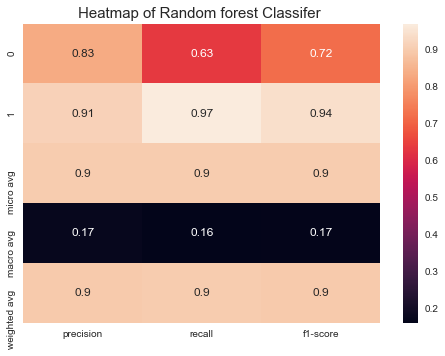

In [28]:
labels = np.arange(10)
target_names=[0,1]
clf_report = classification_report(a[test_indices],y_hat,
                                   labels=labels,
                                   target_names=target_names,
                                   output_dict=True)

ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.title('Heatmap of Random forest Classifer ', fontsize = 15)

### Random Forest ROC Curve Results

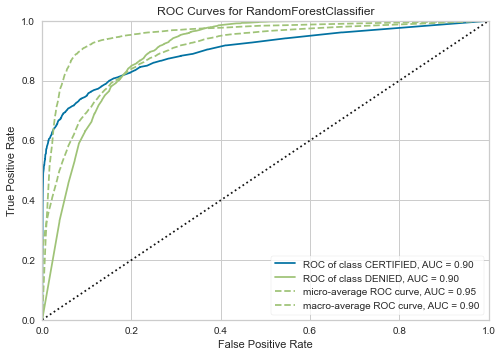

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [29]:
from yellowbrick.classifier import ROCAUC,ClassPredictionError
model = RandomForestClassifier(class_weight="balanced",criterion = 'gini', random_state = 42)
visualizer = ROCAUC(model, classes=["CERTIFIED", "DENIED"])

visualizer.fit(xx_train,yy_train)        
visualizer.score(xx_test,yy_test)        
visualizer.show()

### ADABoost Classifier HeatMap

In [30]:
pipe = Pipeline([('ADB',AdaBoostClassifier(learning_rate=1.0,algorithm = 'SAMME.R',random_state = 42))])
pipe.fit(b[train_indices],a[train_indices])
y_hat = pipe.predict(b[test_indices])

Text(0.5, 1.0, 'Heatmap of ADABoost Classifier')

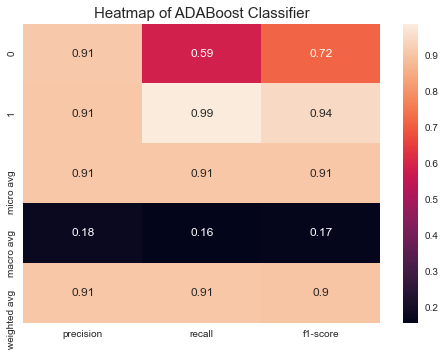

In [31]:
labels = np.arange(10)
target_names=[0,1]
clf_report = classification_report(a[test_indices],y_hat,
                                   labels=labels,
                                   target_names=target_names,
                                   output_dict=True)

ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.title('Heatmap of ADABoost Classifier', fontsize = 15)


### ADABoost ROC Curve Results

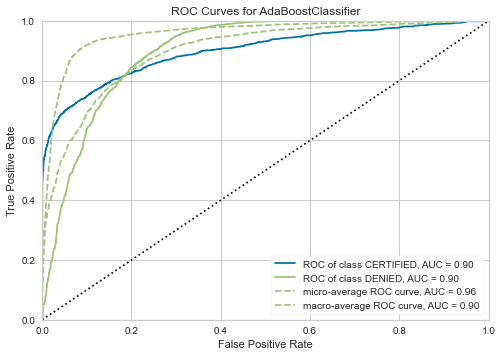

<AxesSubplot:title={'center':'ROC Curves for AdaBoostClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [32]:
mod = AdaBoostClassifier(learning_rate=1.0,algorithm = 'SAMME.R', random_state = 42)
visualizer = ROCAUC(mod, classes=["CERTIFIED", "DENIED"])

visualizer.fit(xx_train,yy_train)        
visualizer.score(xx_test,yy_test)        
visualizer.show()

In [33]:
models = []
#models.append(('BG',knn()))
models.append(('RDF',RandomForestClassifier(random_state=42, class_weight="balanced",criterion='gini')))
models.append(('ADB',AdaBoostClassifier(learning_rate=1.0,algorithm = 'SAMME.R',random_state = 42)))

In [34]:
results = []
names = []
scoring = 'recall'
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, b, a, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RDF: 0.967668 (0.003860)
ADB: 0.985319 (0.003429)


### Precision Comparison Visualization

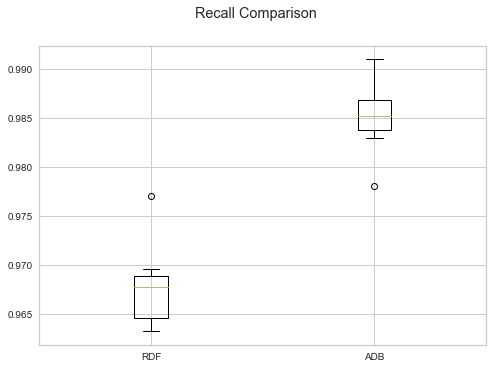

In [35]:
fig = plt.figure()
fig.suptitle('Recall Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [36]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, b, a, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RDF: 0.903752 (0.002992)
ADB: 0.906829 (0.004757)


### Accuracy Comparison Visualization

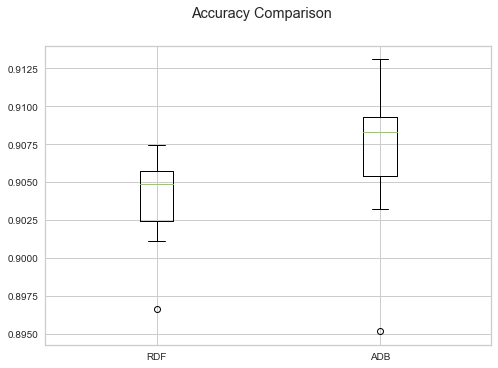

In [37]:
fig = plt.figure()
fig.suptitle('Accuracy Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Modeling and Evaluation 5
#### Model advantages
Random forest<br>
1. Better Recall for the critical category - Denied
2. Better F1 score for the critical category - Denied 


AdaBoost Classifier<br>
1. Better for determing over all Recall for both categories.
2. Better to determine the precision of the Denied category.

In the Overall results recall ADAboost seems to be the better model for recall from the bar charts and the paired t test. The paired t-test suggests that there is significant difference betweens the two models. using mlxtend.evaluate and ensuring that the p-value was less than 0.05, assuming the null hypothesis is that there is no significant difference between the two models. I can say with 95% confidence that the overall recall metric may be better in ADAboost than Random Forest. 

While for accuracy the two models seem to be similar. We can see this with the AUC curve both having the same approximate value of 0.89. Also The results of the paired t-test suggests that with 95% confidence we fail to reject the null hypothesis of the models being the same. In other words the accuracy of the two models may not have signifiicant diffrence in values. 

Best Model<br>
The best model is the Random Forest model because the consequences of having False Negatives particularly in the Denied category is very high vs the tradeoff of advantages of False positives is very low. The false positives of the Denied class would be when If the company is informed that the employee is denied while he/she is Certified there will be little to no negative effect on projects since the company will be well prepared and find alternative measures. So Although ADAboost is a better model as a whole for prediction, it has a lower Denied recall of 0.58 while Random Forest has a Denied recall of 0.63 which is better since predictions for the severe category would be more accurate from this model.


In [38]:
RDF = RandomForestClassifier(class_weight="balanced",criterion = 'gini', random_state = 42)
ADB = AdaBoostClassifier(learning_rate=1.0,algorithm = 'SAMME.R',random_state = 42)

In [39]:
from mlxtend.evaluate import paired_ttest_5x2cv

In [40]:
t, p = paired_ttest_5x2cv(estimator1=ADB, estimator2=RDF, X=b, y=a, scoring='recall', random_seed=1)

In [41]:
if p <= 0.05:
	print('Difference between mean performance is probably real')
else:
	print('Algorithms probably have the same performance')

Difference between mean performance is probably real


In [42]:
t, p = paired_ttest_5x2cv(estimator1=RDF, estimator2=ADB, X=b, y=a, scoring='accuracy', random_seed=1)

In [43]:
if p <= 0.05:
	print('Difference between mean performance is probably real')
else:
	print('Algorithms probably have the same performance')

Difference between mean performance is probably real


In [44]:
#pip install eli5

## Modeling and Evaluation 6

From the tables below we can see that the top 2 most influential features are the DAYS_PROCESS and ANNUALIZED_WAGE_RATE_OF_PAY these seem to be important. Using SelectFromModel from scikit learn we able to select the impurity-based feature importances and the other less important features variable would be discarded. with this model we saw that it selected the top 3 features for the Random forest Classifier while for the AdaBoost the top 5 were selected. 

DAYS_PROCESS should be potentially very important since the decision for Denied or Certified may have have a time range pattern between those that were Certified and Denied that could be detected by our model and made it a good predictor. Also the ANNUALIZED_WAGE_RATE_OF_PAY could be important as there may be consistency with the jobs that they are not finding the skills in the united states may be highly technical and high salary jobs which may also cause better predictions. LABOR_CON_AGREE_Y is also important in the favored model this may mean that when these are considered it would help us tell find our if the will be Denied or not. AGENT_REP_Y is also important in the random forest model we are assuming that if a company does not have an agent it may negatively affect the certification and that is why it may be prominent in our preffered model of Random forest, which is better at predicting the actual denied candidates. Also the SOC_GROUP Computer and Mathematical had a very large number of candidates and seems to be very influential in determining the Certification prediction since this field is highly technical there may be a shortage of people with this skill set, and Denying these candidates may have severe outcome.

In [45]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel

In [57]:
XX = df2.drop(['CASE_STATUS'], axis=1)

perm = PermutationImportance(RDF).fit(xx_train,yy_train)
#eli5.show_weights(perm, feature_names = XX.columns.tolist())

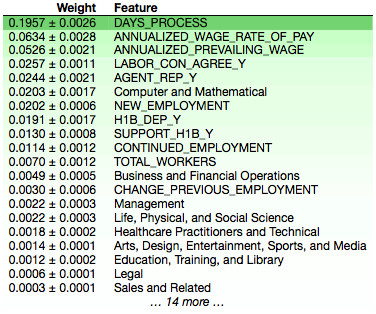

In [47]:
XX = df2.drop(['CASE_STATUS'], axis=1)
feat_labels = XX.columns
clf = RDF.fit(xx_train, yy_train)

In [48]:
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(xx_train)
X_new.shape

for feature_list_index in model.get_support(indices=True):
    print(feat_labels[feature_list_index])

ANNUALIZED_PREVAILING_WAGE
ANNUALIZED_WAGE_RATE_OF_PAY
DAYS_PROCESS


In [58]:
perm = PermutationImportance(ADB).fit(xx_train,yy_train)
#eli5.show_weights(perm, feature_names = XX.columns.tolist())

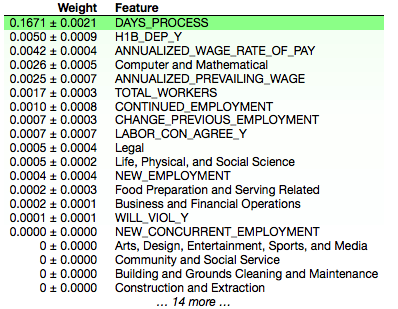

In [50]:
clf = ADB.fit(xx_train, yy_train)

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(xx_train)
X_new.shape

for feature_list_index in model.get_support(indices=True):
    print(feat_labels[feature_list_index])

TOTAL_WORKERS
NEW_EMPLOYMENT
CONTINUED_EMPLOYMENT
ANNUALIZED_PREVAILING_WAGE
ANNUALIZED_WAGE_RATE_OF_PAY
DAYS_PROCESS
Computer and Mathematical
LABOR_CON_AGREE_Y


## Deployment

I think this is very useful because employers will be able to determine the features that they can take into consideration when applying for candidates. For example from this model we understand that having an agent in the process helps ensure that the candidate is Certified (AGENT_REP_Y). Also If the number of days passes by after the application has been put in they may need to start making arrangements for an alternative way to cover the work, since there is a high chance that it may be denied (DAYS_PROCESS). Also when applying for candidates they need to take into consideration if the position is low paying because there may lower chances that the candidiate would be approved (ANNUALIZED_WAGE_RATE_OF_PAY).

I think this model is valuable because it gives insight into the features that are needed for the successful certification of a candidate. Also if all independent features are provided they can run this model beforre they apply for a candidate to see if they would get a positive result. I would measure the models value by how well it predicts the False positives of the Denied class. This prediction can save the company costs and reputaion if they are able to find out that the candidate they are applying for may be denied my running the model and getting a predictive outcome before they put in the application.

Other data that may have been added would have been Age ,Gender and Country of applicant. This model may need to be updated every year so that a new set of applicants can be used to train the data to ensure the analysis is still valid with current applications. 

## Exceptional Work

We are looking at the parameters of AdaBoost the learning rate and comparing it to the number of decision trees in the base_estimator. AdaBoost has a base model parameter that specifies the model the boosted ensemble is built from. In this model we use the decision tree as the base model. We try to see the effect of the parameter by changing the number of trees in the base estimator parameter (decision trees) while using a fixed learnig rate of 1.0 and compare it to the results where we change the learning rate parameter and hold the number of trees in the base estimator constant at 1 tree to see which of these parameters has a larger effect on the results.

Both of the parameters do not have a very large effect on the results however we see that the variance in the results is higher in the algorithm with the learning rate constant and the trees varying, the results range from that range from 0.965 for 5 trees to 0.984 for 1 tree, making a variance of 0.019 while for the constant trees algorithm the results ranged from 0.984 for learning rate of 1 to 0.989 for learning rate of 0.6 for a difference of 0.005.

In conclusion we can say that the number of trees in the base estimator parameter has a larger effect on the results than the change in learning rate for the AdaBoost Classifier. 

In [51]:
models = []
models.append(('1.0',AdaBoostClassifier(learning_rate=1.0,base_estimator=DecisionTreeClassifier(max_depth=1),random_state = 42)))
models.append(('0.9',AdaBoostClassifier(learning_rate=0.9,base_estimator=DecisionTreeClassifier(max_depth=1),random_state = 42)))
models.append(('0.8',AdaBoostClassifier(learning_rate=0.8,base_estimator=DecisionTreeClassifier(max_depth=1),random_state = 42)))
models.append(('0.7',AdaBoostClassifier(learning_rate=0.7,base_estimator=DecisionTreeClassifier(max_depth=1),random_state = 42)))
models.append(('0.6',AdaBoostClassifier(learning_rate=0.6,base_estimator=DecisionTreeClassifier(max_depth=1),random_state = 42)))

In [52]:
results = []
names = []
scoring = 'recall'
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, b, a, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

1.0: 0.985319 (0.003429)
0.9: 0.986103 (0.003026)
0.8: 0.986740 (0.003164)
0.7: 0.987782 (0.002864)
0.6: 0.989124 (0.002509)


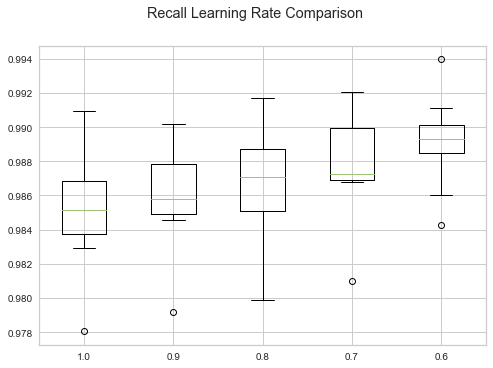

In [53]:
fig = plt.figure()
fig.suptitle('Recall Learning Rate Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [54]:
models = []
models.append(('1tr',AdaBoostClassifier(learning_rate=1.0,base_estimator=DecisionTreeClassifier(max_depth=1),random_state = 42)))
models.append(('2tr',AdaBoostClassifier(learning_rate=1.0,base_estimator=DecisionTreeClassifier(max_depth=2),random_state = 42)))
models.append(('3tr',AdaBoostClassifier(learning_rate=1.0,base_estimator=DecisionTreeClassifier(max_depth=3),random_state = 42)))
models.append(('4tr',AdaBoostClassifier(learning_rate=1.0,base_estimator=DecisionTreeClassifier(max_depth=4),random_state = 42)))
models.append(('5tr',AdaBoostClassifier(learning_rate=1.0,base_estimator=DecisionTreeClassifier(max_depth=5),random_state = 42)))

In [55]:
results = []
names = []
scoring = 'recall'
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, b, a, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

1tr: 0.985319 (0.003429)
2tr: 0.980664 (0.003777)
3tr: 0.977828 (0.004291)
4tr: 0.970747 (0.004458)
5tr: 0.966929 (0.005168)


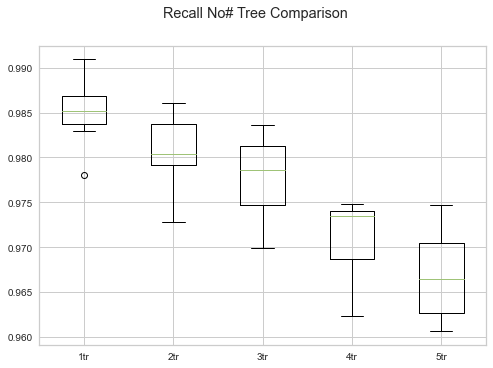

In [56]:
fig = plt.figure()
fig.suptitle('Recall No# Tree Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

https://towardsdatascience.com/entropy-how-decision-trees-make-decisions-2946b9c18c8

https://scikit-learn.org/stable/modules/feature_selection.html
    